In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision medmnist
!pip install git+https://github.com/MedMNIST/MedMNIST.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=9feb27c19bdb7854fd38ed59fc5a1bed00feae733bf18df2e7aad3fb706ec376
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Cloning https://github.com/MedMNIST/MedMNIST.git to /tmp/pip-req-build-mkpybp3d
  Running command git clone --filter=blob:none --quiet https://github.com/MedMNIST/MedMNIST.git /tmp/pip-req-build-mkpybp3d
  Resolved https://github.com/MedMNIST/MedMNIST.git to commit bb515b40124458cfeb14d37d8f0095511d4e916b
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install scikit-learn
from sklearn.metrics import roc_auc_score

**Code to load images / labels and saved model to classify the images.
Final version with good results!!**

In [ ]:
# much needed definitions
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import medmnist
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from tqdm import tqdm

# Load and preprocess dataset (224x224 resolution)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained model normalization
])

# Define the Model with ResNet18 pretrained
class PathMNISTClassifier(nn.Module):
    def __init__(self, num_classes=9):  # PathMNIST has 9 classes
        super(PathMNISTClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)

        # Modify the final fully connected layer to match the number of classes in PathMNIST
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Function to unnormalize an image
def unnormalize(tensor, mean, std):
    """Unnormalizes a tensor image with mean and standard deviation."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


Testing saved images:
Image 1:
  -- True Label: colorectal adenocarcinoma epithelium (8)
  -- Predicted Label: colorectal adenocarcinoma epithelium (8)


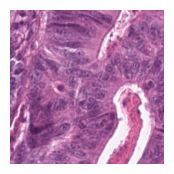

Image 2:
  -- True Label: normal colon mucosa (6)
  -- Predicted Label: normal colon mucosa (6)


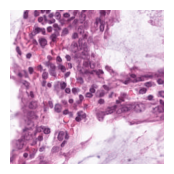

Image 3:
  -- True Label: background (1)
  -- Predicted Label: background (1)


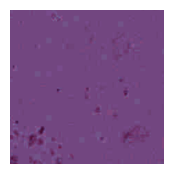

Image 4:
  -- True Label: mucus (4)
  -- Predicted Label: mucus (4)


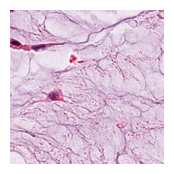

Image 5:
  -- True Label: cancer-associated stroma (7)
  -- Predicted Label: colorectal adenocarcinoma epithelium (8)


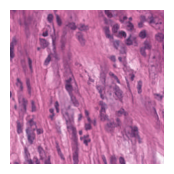

Image 6:
  -- True Label: normal colon mucosa (6)
  -- Predicted Label: normal colon mucosa (6)


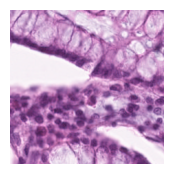

Image 7:
  -- True Label: colorectal adenocarcinoma epithelium (8)
  -- Predicted Label: colorectal adenocarcinoma epithelium (8)


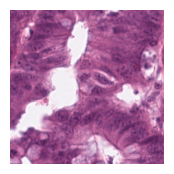

Image 8:
  -- True Label: smooth muscle (5)
  -- Predicted Label: smooth muscle (5)


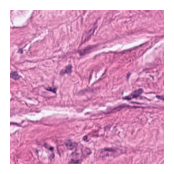

Image 9:
  -- True Label: colorectal adenocarcinoma epithelium (8)
  -- Predicted Label: colorectal adenocarcinoma epithelium (8)


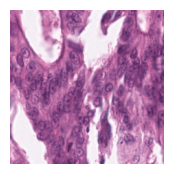

Image 10:
  -- True Label: colorectal adenocarcinoma epithelium (8)
  -- Predicted Label: colorectal adenocarcinoma epithelium (8)


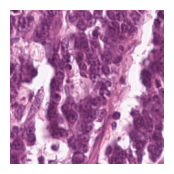

In [ ]:
#. Load images/ labels and load the model to classify
#  Log True vs Predicted labels to confirm classification quality.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import medmnist
from medmnist import INFO, PathMNIST
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import numpy as np
import seaborn as sns
import os
from PIL import Image

save_dir = "/content/drive/MyDrive/ColabNotebooks/PathMnistTestData/"  # Directory to load images from
labels_file_path = os.path.join(save_dir, "labels.txt")  # Path for labels file

# --- Load saved images and create testsaved_loader ---
testsaved_data = []
with open(labels_file_path, "r") as labels_file:  # Open labels file for reading
    for line in labels_file:
        image_name, label = line.strip().split(",")  # Get image name and label
        image_path = os.path.join(save_dir, image_name)
        image = Image.open(image_path).convert('RGB')
        testsaved_data.append((image, int(label)))  # Append to testsaved_data

testsaved_loader = DataLoader(CustomDataset(testsaved_data, transform=transform), batch_size=1)

# --- Test with saved model and compare results ---
# Load the best model
model_path = '/content/drive/MyDrive/ColabNotebooks/pathmnist_224_best_auc_model.pth'
model = PathMNISTClassifier(num_classes=9)
#model.load_state_dict(torch.load(model_path))
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()  # Set the model to evaluation mode

# Get the label names from the PathMNIST info
info = INFO['pathmnist']
label_names = list(info['label'].values())

print("\nTesting saved images:")
for i, (saved_image, saved_label) in enumerate(testsaved_loader):
    # Make predictions
    saved_output = model(saved_image)
    _, saved_predicted = torch.max(saved_output, 1)

    # Get text labels for true and predicted labels
    true_label_name = label_names[saved_label.item()]
    predicted_label_name = label_names[saved_predicted.item()]

    print(f"Image {i + 1}:")
    print(f"  -- True Label: {true_label_name} ({saved_label.item()})")
    print(f"  -- Predicted Label: {predicted_label_name} ({saved_predicted.item()})")

   # Unnormalize the image before displaying
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    unnormalized_image = unnormalize(saved_image.clone().squeeze(), mean, std)  # Clone to avoid modifying the original

    # Display the unnormalized image
    plt.figure(figsize=(2, 2))
    plt.imshow(unnormalized_image.permute(1, 2, 0).clip(0, 1))  # Clip to [0, 1] range
    plt.axis('off')
    plt.show()

**Backup Code:
Code to load Test-Dataset**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import medmnist
from medmnist import INFO, PathMNIST
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Load and preprocess dataset (224x224 resolution)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained model normalization
])

info = INFO['pathmnist']
DataClass = getattr(medmnist, info['python_class'])

# Load the PathMNIST dataset with the desired resolution:
# train_dataset = PathMNIST(split='train', download=True, transform=transform, as_rgb=True, size=224)
# val_dataset = PathMNIST(split='val', download=True, transform=transform, as_rgb=True, size=224)
test_dataset = PathMNIST(split='test', download=True, transform=transform, as_rgb=True, size=224)

# DataLoader for training, validation, and testing
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 12.6G/12.6G [09:37<00:00, 21.9MB/s]


**Code to display all labels**

In [ ]:
import medmnist

# Get info for PathMNIST
info = medmnist.INFO['pathmnist']

# Print the list of text labels
print("Text labels for PathMNIST:", info['label'])

label_text_values = list(info['label'].values())  # Get all values from label_text dictionary
print (label_text_values)

Text labels for PathMNIST: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
['adipose', 'background', 'debris', 'lymphocytes', 'mucus', 'smooth muscle', 'normal colon mucosa', 'cancer-associated stroma', 'colorectal adenocarcinoma epithelium']


**Code to classify test-datatset**

In [ ]:
# code to check classification on test-dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import medmnist
from medmnist import INFO, PathMNIST
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score
import numpy as np


# Load the best model
model_path = '/content/drive/MyDrive/ColabNotebooks/pathmnist_224_best_auc_model.pth'
model = PathMNISTClassifier(num_classes=9)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Test and get predictions
all_true_labels = []
all_predicted_labels = []
all_predicted_probs = []  # For AUC calculation

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
        # Corrected: Use append instead of extend
        for label in labels.cpu().numpy():
            all_true_labels.append(label.item())
        for predicted_label in predicted_labels.cpu().numpy():
            all_predicted_labels.append(predicted_label.item())
        all_predicted_probs.extend(outputs.cpu().numpy()) # Extend is fine here as we need the full probability distribution

# Print true and predicted classes
label_names = list(info['label'].values())  # Get all values from label_text dictionary

for i in range(len(all_true_labels)):
    true_label_num = all_true_labels[i]
    predicted_label_num = all_predicted_labels[i]
    true_label_text = label_names[true_label_num]  # Get text label
    predicted_label_text = label_names[predicted_label_num]  # Get text label

    print(f"Sample {i+1}:")
    print(f"  True: {true_label_num} ({true_label_text})")
    print(f"  Predicted: {predicted_label_num} ({predicted_label_text})")

In [ ]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

Overall Confusion Matrix:
[[1169    0    0    0    1  168    0    0    0]
 [   0  847    0    0    0    0    0    0    0]
 [   0   11  314    0    2   12    0    0    0]
 [   0    0   23  610    0    0    0    0    1]
 [   7    5    0    0  985   27    6    0    5]
 [   0   55   48    0    0  486    0    3    0]
 [   0    0    0    0    0    0  732    0    9]
 [   0    0   37    7    6   82    0  272   17]
 [   0    0    2    4    4    2   24    1 1196]]

Confusion Matrices for Each Label:

Confusion Matrix for adipose:
[[5835    7]
 [ 169 1169]]

Confusion Matrix for background:
[[6262   71]
 [   0  847]]

Confusion Matrix for debris:
[[6731  110]
 [  25  314]]

Confusion Matrix for lymphocytes:
[[6535   11]
 [  24  610]]

Confusion Matrix for mucus:
[[6132   13]
 [  50  985]]

Confusion Matrix for smooth muscle:
[[6297  291]
 [ 106  486]]

Confusion Matrix for normal colon mucosa:
[[6409   30]
 [   9  732]]

Confusion Matrix for cancer-associated stroma:
[[6755    4]
 [ 149  272]]

C

**Code to display the results from classification of Test-Dataset**

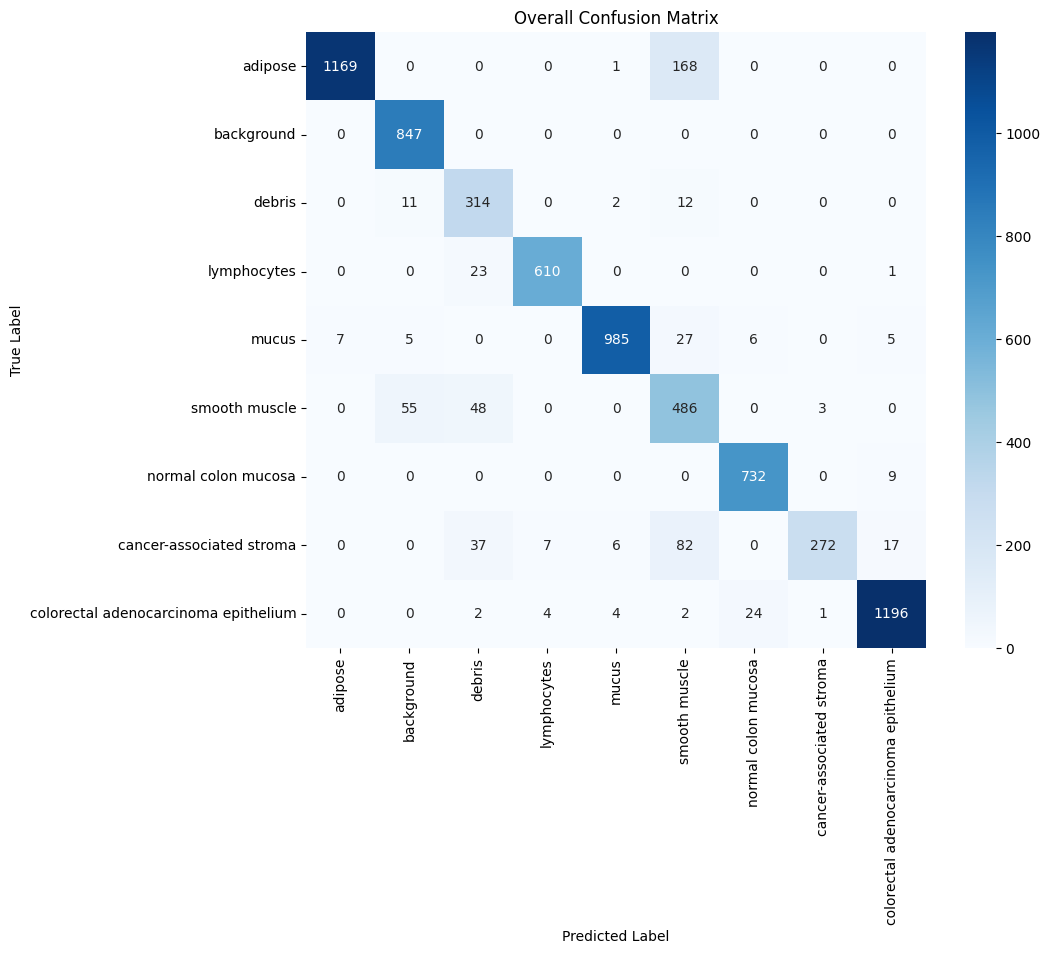


Confusion Matrices for Each Label:


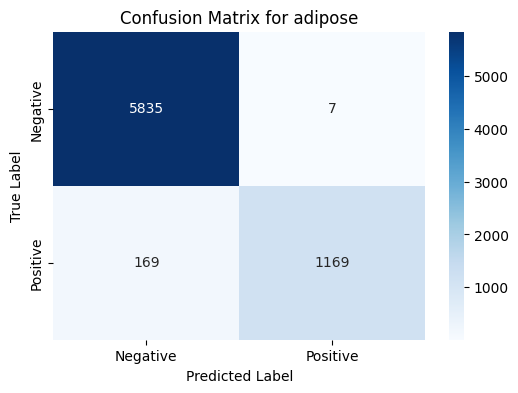

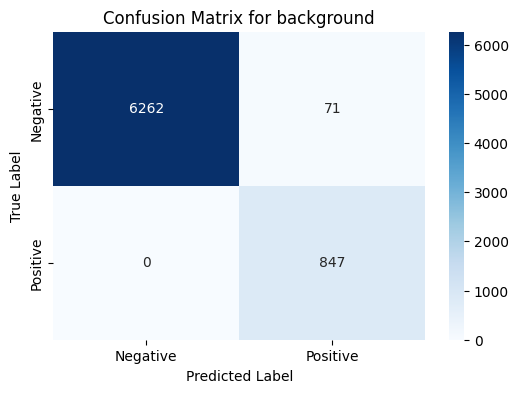

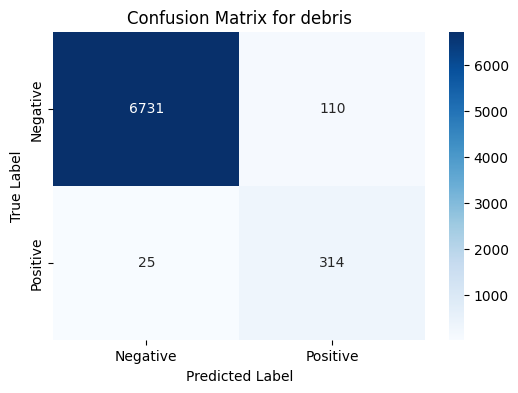

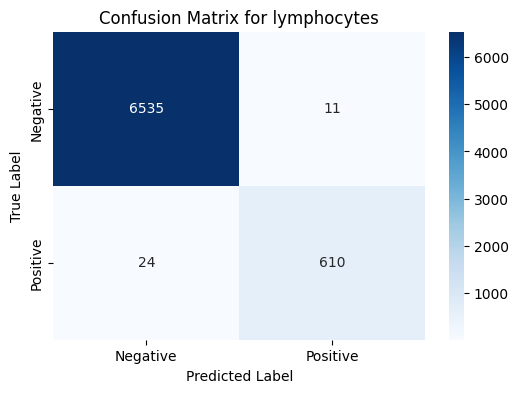

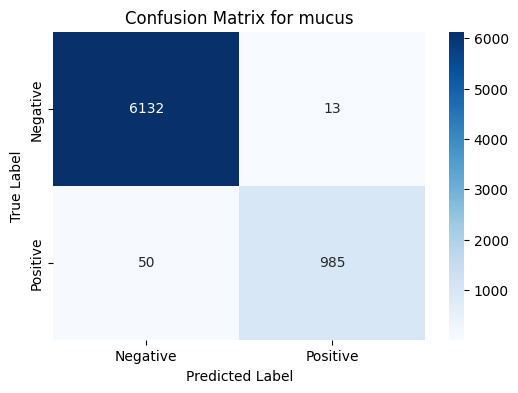

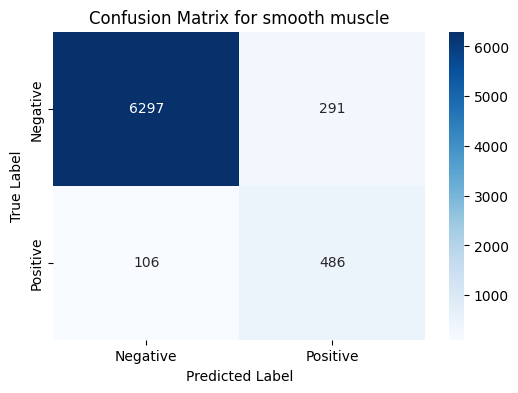

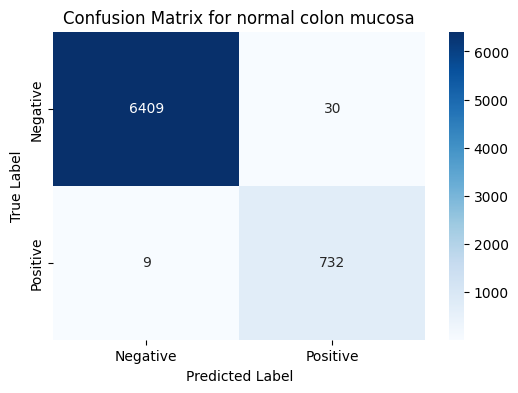

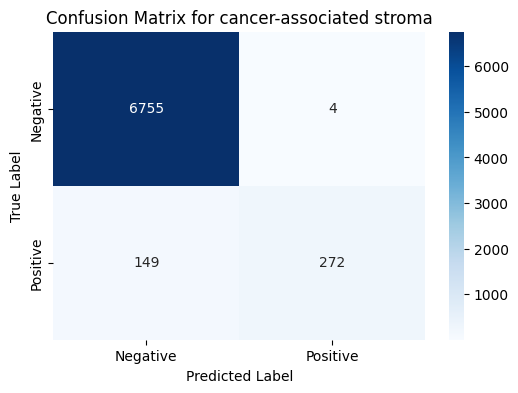

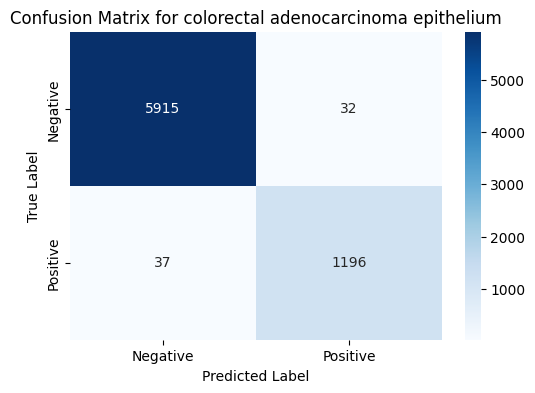

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import numpy as np
import seaborn as sns # Import seaborn for better visualization

# ... (Rest of the code remains the same)

# 7. Calculate and plot confusion matrices for each label
label_names = list(info['label'].values())
num_classes = len(label_names)

# Overall confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Overall Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Confusion matrix for each label using multilabel_confusion_matrix
mcm = multilabel_confusion_matrix(all_true_labels, all_predicted_labels, labels=range(num_classes))

print("\nConfusion Matrices for Each Label:")
for i, label_name in enumerate(label_names):
    plt.figure(figsize=(6, 4))
    sns.heatmap(mcm[i], annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f"Confusion Matrix for {label_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()